# Anatomy of Probabilistic Programming Languages


<br/>
<br/>


### <center> Suriyadeepan Ramamoorthy <center>

## Frequentist

- Probabilities make sense only if there is some repeating event
- Probability over parameters don't make sense since there is only one true parameter
- Learning is the task of searching for this one true parameter

## Bayesian

- Probabilities are about uncertainty
- We are uncertain about the parameters of our model since models are approximations


## Why Bayesian Modeling?

- Small data
- Model uncertainty
- Transparency/Interpretability
- No more loss hacking
- Easy to impose constraining knowledge (as priors)
- Easy to combine information from different types of sensors

## Uncertainty

- There is uncertainty inherent in data due to incompleteness and measurement noise
- This uncertainty propogates to the model
- Unless we explicitly account for this uncertainty in the model, we have no means of measuring and managing it

## Model

- Models are approximations of a real world phenomenon
- Models are built based on our knowledge of the data generating process
- Data-driven models combine expert insight with observed data
- Human insight constraints the space of models




## Frequentist Model

A frequentist model (think Linear Regression $y=wx +b\ $) is a (deterministic) mapping from features to output. 

- Features : $x = [x_1, x_2, .. x_n]$ 
- Model : $y = wx + b$
- Output : $y\ \epsilon\ (-\inf, +\inf)$
    

## Probabilistic Model

A probabilistic model represent a joint probability of observed and latent variables (factors).
Variables are probability distributions.

- Observed Variable : x
- Model : (Joint Distribution) $p(x, y)$
    - Latent Variable : $w \sim \mathcal{N}(w_{loc}, w_{scale})$
    - Latent Variable : $b \sim \mathcal{N}(b_{loc}, b_{scale})$
    - $y \sim \mathcal{N}(wx + b)$
- Outcome Variable : y
    - Observed Variable during Inference
        - $p(w | x = ..., y = ... )$
        - $p(b | x = ..., y = ... )$


## Probabilistic Programming

- Python Constructs (if, while, ...)
    - Recursion
    - Higher order Functions
- Randomness
    - Distributions
         - Normal
         - Bernoulli

## Distributions

A distribution must have these 3 methods:

- sample
- score
- support


# Normal

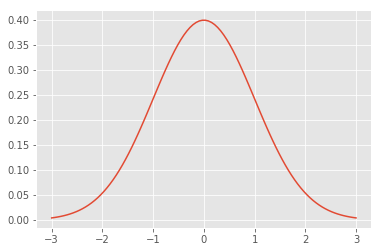

In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
x = np.linspace(-3., 3., 100)
plt.plot(x, stats.norm.pdf(x, 0., 1.))

# Normal

In [1]:
import torch.distributions as tdist
d = tdist.Normal(0., 1.)
d.sample(), d.support, d.log_prob(0.5), d.log_prob(-0.5)

(tensor(0.9652), Real(), tensor(-1.0439), tensor(-1.0439))

# Bernoulli

In [2]:
d = tdist.Bernoulli(0.5)
d.sample(), d.support

(tensor(1.), Boolean())

## How to encode a model in python?

We would like to write the joint probability $p(x, z)$ as a function.

```python
def model(x, y):
    w = sample('w', Normal(0., 1.))
    b = sample('b', Normal(0., 1.))
    y_mean = w*x + b
    y_sample = sample('y', Normal(y_mean, 1.))
    return y_sample
```

## How to learn from data?

- To learn from data, we need to track the variables of interest
- In this case, `w` and `b` are our latent variables which should be inferred from the data
- `y` is the observed variable during inference
- **How do we track these variables?**

## Tracking Variables

- Notice that every variable of interest is associated with a `sample` call
- To track the variables, we make the `sample` call "effectful"
- In addition to just returning a sample from the distribution, `sample` call adds the "sample site" to a global registry.

## Enter the Stack

In [4]:
STACK = []

# Learning Variables

- The variables are *parametric* probability distributions ($w \sim N(0., 1.)$)
- Learning variables means learning the parameters of these distributions
- Know the difference between *latent variables* and *parameters*

![](https://i.imgur.com/1CyonQG.png)


# Learning Variables

$$p(x,z) = p(x)p(z|x) = p(x|z)p(z)$$
$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$
$$p(z|x) = \frac{p(x,z)}{\int p(x,z)\ dz}$$

<center> Learning the posterior $p(z|x)$ analytically is impossible (or just insanely hard). <center>

# Variational Inference

- We introduce a new parametric distribution $q_{\phi}(z)$, parameterized by $\phi$ (variational parameters)
- Pyro developers chose to call this a *guide*

The idea is to consider $q$ as an approximation to the true posterior $p(z\ |\ x)$ and optimize it to be as close as possible to the posterior, while maintaining the simplicity of $q$.

![](https://i.imgur.com/5HGBpcb.png)


# Variational Inference


**Mean-Field Assumption**

$q$ is typically chosen as a factorizable distribution

$$q(z) = q(z_1)q(z_2)...q(z_m)$$

**Exponential Family**

$$q(z) = \mathcal{N}(loc_{z_1}, scale_{z_1})\mathcal{N}(loc_{z_2}, scale_{z_2})...\mathcal{N}(loc_{z_m}, scale_{z_m})$$

**Note** : Latent variables get the bayesian treatment; (Variational) Parameters don't.

## Encode guide as a function

```python
def guide(x, y):
  """ Variational Parameters """
  w_loc = param('w_loc', 0.)
  w_scale = param('w_scale', 1.)  # +ve
  b_loc = param('b_loc', 0.)
  b_scale = param('b_scale', 1.)  # +ve

  """ Latent Variables """
  w = sample('w', Normal(w_loc, w_scale))
  b = sample('b', Normal(b_loc, b_scale))
```

- `param` calls are effectful
- The `param` function stores the parameters with names to the `PARAM_STORE`

```python
PARAM_STORE = {}
```

# Inference

- We have turned inference to an optimization problem
- But what is the objective function? 
    - We need our approximation to be as close as possible to the intractable posterior
    - **Intractable** Posterior!!!

![](https://i.imgur.com/XgbxrhO.png)


# Monte-Carlo Approximation

$$L = \int_z q(z)\ log\frac{p(x, z)}{q(z)}$$

When you see an intractable integral, you think *Monte Carlo Approximation*.

$$L = \mathbb{E}_{q_{\phi}(z)}\ \big{[}log\ p_{\theta}(x,z) - log\ q_{\phi}(z)\big{]}$$

- $log\ p_{\theta}(x, z)$
    - Log Probability of sample $z \sim q(z)$ evaluated under model $p(x,z)$
    - We add up individual log probabilites of $z_1, z_2, .. z_m$
        - Because, *Mean-field assumption* baby!
    - $\{w, b\}$ in our case
- $log\ q_(z)$
    - Log probability of sample $z \sim q(z)$ evaluated under guide $q(z)$

# Being Bayesian

![](https://www2.isye.gatech.edu/~brani/isyebayes/bank/bayesfun.jpg)

## Implementing Inference

- Remember the registry? I lied
    - It's not exactly a registry
- The `sample` statements are encoded as messages
    - sent to a bunch of listeners or handlers that will make use of the messages

## Message Encoding

```python
msg = {
    'name' : 'w',
    'type' : 'sample',  # there are other types? yeah.. hang in there!
    'fn'   : Normal(0., 1.),
    'stop' : False  # a handler decides to set this, so other handlers don't   touch this msg
}
```

- The `param` function also creates a message (of type `param`) and sends it to thhe handlers.



## Handlers

The handlers deal with the messages (sample sites). Types of handlers : 

- Trace : Just take a copy of all the messages
- Block : If a condition succeeds, set `'stop' = False`
- Replay
    - Run a model by reusing samples from guide
    - Implemented to support Monte-Carlo ELBO
    - Calculate log probability density of samples from guide $q(z)$ under the model $p(x,z)$
    
- Handlers are designed to support inference
- There will be multiple handlers at work at the same time, as we will see later
- The handlers are put in a stack. The messages are passed through the stack

## ELBO Implementation

```python
def elbo(model, guide, *args, **kwargs):
    # run guide with args
    # record `sample` and `param` calls
    guide_trace = trace(guide).get_trace(*args, **kwargs)
    # trace model execution
    # replay : reuse sampled values from guide trace
    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)
    # elbo
    elbo = 0.
    # iterate through sample sites in model
    # add log_p(z) term to ELBO
    for site in model_trace.values():
        if site['type'] == 'sample':
            elbo = elbo + site['fn'].log_prob(site['value']).sum()
    # iterate through sample sites in guide
    # add log_q(z) term to ELBO
    for site in guide_trace.values():
        if site['type'] == 'sample':
            elbo = elbo - site['fn'].log_prob(site['value']).sum()
    return -elbo  # because we minimize
```

## Stochastic Variational Inference

```python
class SVI(object):
  
  ...
    
  def step(self, *args, **kwargs):
    # run trace to capture parameter values
    with trace() as param_capture:
      # block `sample` sites from trace; capture only parameters
      with block(hide_fn=lambda msg : msg['type'] == 'sample'):
        # calculate loss
        loss = self.loss_fn(self.model, self.guide, *args, **kwargs)
        
    # calculate gradients
    loss.backward()
    # grab parameters from trace
    params = [ site['value'].unconstrained()
        for site in param_capture.values() ]
    # run optimizer; update params
    self.optimizer(params)
    for p in params:  # clear gradients
      p.grad = p.new_zeros(p.shape)
    return loss.item()
```

# Latent Normal

```python
  def model(data):
    z_loc = pyro.sample('z_loc', pdist.Normal(0., 1.))
    # normally distributed observations
    # for datapoint in data:
    pyro.sample('obs', pdist.Normal(z_loc, 1.), obs=data)
    # break

  def guide(data):
    # define parameters
    #  loc and scale for latent variable `z_loc`
    guide_loc = pyro.param('guide_loc', torch.tensor(0.))
    guide_scale = pyro.param('guide_scale', torch.tensor(1.),
        constraint=constraints.positive
        )
    # we would like to learn the distribution `loc`
    pyro.sample('z_loc', pdist.Normal(guide_loc, guide_scale))
```

# Latent Normal

ELBO | Parameter
- | - 
![alt](images/1_elbo.png) | ![alt](images/1_param.png)

![](images/1_density.png)


# Linear Regression

```python
def model(x, y):
  w = pyro.sample('w', pdist.Normal(0., 1.))
  b = pyro.sample('b', pdist.Normal(0.5, 1.))
  mean = w * x + b
  pyro.sample('obs', pdist.Normal(mean, 0.01), obs=y)
  return mean

def guide(x, y):
  w_loc = pyro.param('w_loc', torch.tensor(1.))
  w_scale = pyro.param('w_scale', torch.tensor(1.),
      constraint=constraints.positive
      )
  b_loc = pyro.param('b_loc', torch.tensor(0.))
  b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)
  w = pyro.sample('w', pdist.Normal(w_loc, w_scale))
  b = pyro.sample('b', pdist.Normal(b_loc, b_scale))
```

# Linear Regression

Posterior Predictive | Parameter Density
- | - 
![](images/2_posterior.png) | ![a](images/2_w_density.png)
![a](images/2_w.png)         | ![a](images/2_b.png)

# Bayesian Neural Network

```python
def model(x, y):
  w1 = pyro.sample('w1', pdist.Normal(0., 1.))
  b1 = pyro.sample('b1', pdist.Normal(0., 1.))
  w2 = pyro.sample('w2', pdist.Normal(0., 1.))
  b2 = pyro.sample('b2', pdist.Normal(0., 1.))
  # define model
  mean = w2 * torch.tanh(w1 * x + b1) + b2
  pyro.sample('obs', pdist.Normal(mean, 0.01), obs=y)
  return mean

```


# Bayesian Neural Network

```python
def guide(x, y):
  w_loc_1 = pyro.param('w_loc_1', torch.tensor(0.))
  w_scale_1 = pyro.param('w_scale_1', torch.tensor(1.),
      constraint=constraints.positive
      )
  b_loc_1 = pyro.param('b_loc_1', torch.tensor(0.))
  b_scale_1 = pyro.param('b_scale_1', torch.tensor(1.), constraint=constraints.positive)

  w_loc_2 = pyro.param('w_loc_2', torch.tensor(0.))
  w_scale_2 = pyro.param('w_scale_2', torch.tensor(1.),
      constraint=constraints.positive
      )
  b_loc_2 = pyro.param('b_loc_2', torch.tensor(0.))
  b_scale_2 = pyro.param('b_scale_2', torch.tensor(1.), constraint=constraints.positive)
  w1 = pyro.sample('w1', pdist.Normal(w_loc_1, w_scale_1))
  b1 = pyro.sample('b1', pdist.Normal(b_loc_1, b_scale_1))
  w2 = pyro.sample('w2', pdist.Normal(w_loc_2, w_scale_2))
  b2 = pyro.sample('b2', pdist.Normal(b_loc_2, b_scale_2))
```

# Bayesian Neural Network


_ | _
- | - 
![](images/3_three_points.png) | ![a](images/3_one_point.png)


# Bayesian Neural Network

![](images/3_real_three_points.png)

# Logistic Regression

```python
def model(x, y):
  w = pyro.sample('w', pdist.Normal(torch.zeros(4), torch.ones(4)))
  b = pyro.sample('b', pdist.Normal(0., 1.))
  y_hat = torch.sigmoid((w * x).sum(dim=1) + b)
  pyro.sample('obs', pdist.Bernoulli(y_hat), obs=y)

def guide(x, y):
  w_loc = pyro.param('w_loc', torch.zeros(4))
  w_scale = pyro.param('w_scale', torch.ones(4),
      constraint=constraints.positive
      )
  b_loc = pyro.param('b_loc', torch.tensor(0.))
  b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)
  w = pyro.sample('w', pdist.Normal(w_loc, w_scale))
  b = pyro.sample('b', pdist.Normal(b_loc, b_scale))
```

# Logistic Regression


```
[1.0] 995/1000 with 99.5% certainty
[0.0] 981/1000 with 98.1% certainty
[1.0] 989/1000 with 98.9% certainty
[0.0] 993/1000 with 99.3% certainty
[1.0] 999/1000 with 99.9% certainty
[0.0] 997/1000 with 99.7% certainty
[1.0] 996/1000 with 99.6% certainty
[1.0] 997/1000 with 99.7% certainty
[0.0] 932/1000 with 93.2% certainty
[0.0] 996/1000 with 99.6% certainty
[0.0] 982/1000 with 98.2% certainty
[1.0] 994/1000 with 99.4% certainty
[1.0] 999/1000 with 99.9% certainty
[1.0] 993/1000 with 99.3% certainty
```

## References

- Code : [suriyadeepan/anatomy-of-ppl](https://github.com/suriyadeepan/anatomy-of-ppl)
- Osvaldo Martin's [Bayesian Analysis with Python](https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python-second-edition)
- Uber's [Pyro](http://pyro.ai/)
- Noah Goodman's [The Design and Implementation of Probabilistic Programming Languages](http://dippl.org/)